In [1]:
# Importing stuff
import numpy as np
from scipy import linalg as la
from os import walk
from scipy.ndimage import imread
from matplotlib import pyplot as plt
from random import sample

%matplotlib inline

# Facial Recognition Using Eigenfaces

## Summary

Facial recognition is quickly emerging as a valuable and marketable technology. Currently, different types of facial recognition are used by Snapchat, Facebook, and various law enforcement agencies, and there is potential to use the ideas in other areas as well. In this notebook, we explore how we can use the singular value decomposition to create a simple facial recognition system.

## Set Up

The first thing we do is load and store a dataset containing images of 153 people, and each person has multiple images associated with them. This dataset can be found at http://cswww.essex.ac.uk/mv/allfaces/faces94.html.

In [2]:
def getFaces(path="./faces94"):
    """Traverse the directory specified by 'path' and return an 
    array containing one column vector per subdirectory.
    
    For the faces94 dataset, this gives an array with just one
    column for each face in the dataset. Each column corresponds
    to a flattened grayscale image.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in walk(path):
        for f in filenames:
            if f[-3:]=="jpg": # only get jpg images
                # load image, convert to grayscale, flatten into vector
                face = imread(dirpath+"/"+f).mean(axis=2).ravel()
                faces.append(face)
                break
                
    # put all the face vectors column-wise into a matrix.
    F = np.array(faces).T
    return F

def sampleFaces(n_tests, path="./faces94"):
    """Return an array containing a sample of n_tests images
    contained in the path as flattened images in the columns of 
    the output.
    """
    files = []
    for (dirpath, dirnames, filenames) in walk(path):
        for f in filenames:
            if f[-3:]=="jpg": # only get jpg images
                files.append(dirpath+"/"+f)
    # Get a sample of the images
    test_files = sample(files, n_tests)
    # Flatten and average the pixel values
    images = np.array([imread(f).mean(axis=2).ravel() for f in test_files]).T
    return images

In addition, we write this helper function to help to display a given image from the dataset. Then we display a face to demonstrate what the output will look like.

In [3]:
# helper function to accept and display flattened image
def displayimage(A):
    A = A.reshape(200,180)
    plt.imshow(A, cmap='gray')
    plt.show()

The following is a face from the dataset

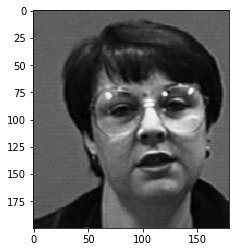

In [4]:
F = getFaces()
displayimage(F[:,0])

Next, we write a class that will be used to implement the system. Each aspect of the class will be demonstrated later on in the notebook.

In [5]:
# class for Facial Recognition system:
class FacialRec:
    # initializes the FacialRec class
    def __init__(self,path):
        self.initFaces(path)
        self.initMeanImage()
        self.initDifferences()
        self.initEigenfaces()
    
    # Loads the faces from the dataset and stores them
    def initFaces(self, path):
        self.F = getFaces(path)
        self.k = len(self.F[0])
        
    # Creates and stores the mean face
    def initMeanImage(self):
        self.mu = np.sum(F,axis=1)/self.k
    
    # Creates and stores Fbar, a matrix of mean-shifted faces
    def initDifferences(self):
        MU = self.mu
        for i in xrange(1,self.k):
            MU = np.vstack((MU,self.mu))
        self.Fbar = self.F - MU.T

    # Uses the SVD to store U, a collection of eigenfaces
    def initEigenfaces(self):
        U, E, Vh = la.svd(self.Fbar, full_matrices=False)
        self.U = U
        
    # Projects a face vector onto an s dimensional subspace
    def project(self, A, s=38):
        if A.ndim == 1:
            return np.dot(self.U[:,:s].T, A)
        else:
            proj = np.dot(self.U[:,:s].T, A[:,0])
            for j in xrange(1, len(A[0])):
                proj = np.vstack((proj, np.dot(self.U[:,:s].T, A[:,j])))
            return proj.T
    
    def findNearest(self, image, s=38):
        Fhat = self.project(self.Fbar, s)
        ghat = self.project(image - self.mu, s)
        GHAT = ghat
        for i in xrange(1,len(Fhat[0])):
            GHAT = np.vstack((GHAT,ghat))
        GHAT = GHAT.T
        return np.argmin(np.linalg.norm(Fhat-GHAT,axis=0))

## The Mean Face

Each face from the dataset can be represented by a matrix of numbers, where each number represents the color value of a pixel. We will choose to represent the faces as vectors by taking these matrices and flattening them. 

The first step in the facial recognition algorithm is to find the "mean face," or the vector where each pixel value is the average of all pixel values in that corresponding location accross the whole dataset. The initMeanImage() function in the FacialRec class does this. We show the mean face here.

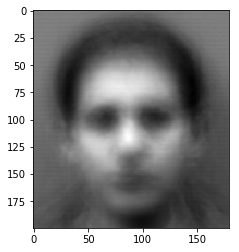

In [6]:
fr = FacialRec("./faces94")
displayimage(fr.mu)

## Mean-shifted Faces

Humans instinctively have the ability to recognize differences in faces and distinguish between people. Computers can do this as well, but we have to tell them what to look for. In particular, for this facial recognition algoritm, the computer needs to know how "far off" a particular image is from the mean face. This allows the computer to recognize the unique features of the image. 

To implement this idea, we "shift" a face by the mean by subracting it from the mean face vector. We do this for all images in the dataset and store the result as a class variable called Fbar.

We display one of these images below, followed by the original face for comparison.

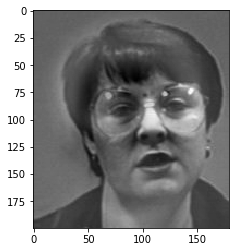

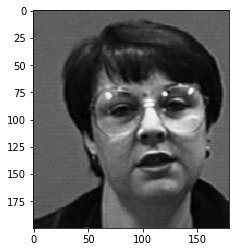

In [7]:
displayimage(fr.Fbar[:,0])
displayimage(fr.F[:,0])

## Subspace Projection

So, if we are given any new face vector representing a face in our dataset, we first shift that face by the mean face. Then we compare the difference between the mean-shifted new face and all mean-shifted faces in our dataset, and the one in the dataset that minimizes the difference is the corresponding face.

Seems like problem solved, right? Well, not technically yes, but we have a new problem now. That is that the amount of time it would take to compare the entire new face vector with all the face vectors in the dataset would make this method infeasible for large datasets or for large face vectors.

We resolve this problem by projecting the face on to a subspace, which is basically to say that we focus on only the portions of the face vectors that will provide us with the most information. We then only have to compare the projected portions of the face vectors, thus significantly reducing the cost of comparison. The dataset we are using has 153 "different bits of information," but we want to recognize faces using significantly less memory and computation than that. 

It can be shown that the s dimensional subspace that provides the most useful information is the span of the first s vectors of $U$, where $U$ is produced by the Singular Value Decomposition (SVD) of Fbar. We want to store this $U$ for all of the faces in the dataset for easy access. Hence, we create the method initEigenfaces(), which takes the SVD of Fbar and stores the produced $U$ as a class variable. We refer to the vectors in $U$ as "eigenfaces."

Below, we show a couple of eigenfaces. Notice that each one highlights a unique aspect of the face.

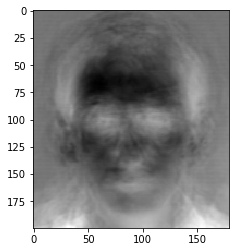

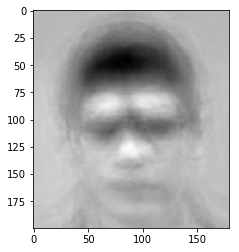

In [8]:
# Displays eigenfaces
displayimage(fr.U[:,0])
displayimage(fr.U[:,1])

Now that we have produced these eigenfaces, we need to have a method that projects a given face onto the subspace generated by these eigenfaces. In other words, we need a method that produces the aforementioned face vectors that provide only the most useful information. The project() method does exacly this.

Below, we show a face that has been projected onto a 19 dimensional subspace, as well as the original face for comparison. Notice that the original image is a 153 dimensional subspace, so we've decreased the amount of information significantly, however the face is still recognizable to humans. We will shortly show that 19 dimensions is enough to be recognizable to computers as well.

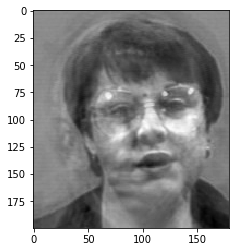

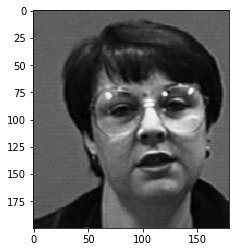

In [10]:
face = fr.Fbar[:,0]
proj_face = fr.project(face,s=19) # projects face onto 19 dim space
std_basis_face = np.dot(fr.U[:,:19],proj_face) 
displayimage(std_basis_face+fr.mu) # projected face
displayimage(fr.F[:,0]) # original face

## Conclusion

With the projection method in place, we are now ready to utilize these ideas to identify random faces. The findNearest() method accepts a face vector and an integer s for the dimension of the subspace to be used. This method then follows the procedure described above by projecting the collection of face vectors and the given face vector to an s dimensional subspace, finding which image is nearest, and returning the index where that image can be found.

Below we demonstrate this for a few randomly selected faces from the dataset. The function sampleFaces() selects a few random faces from the dataset to use for demonstration.

Randomly selected image:


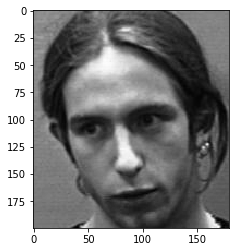

Computer recognized image:


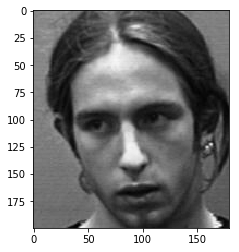

Randomly selected image:


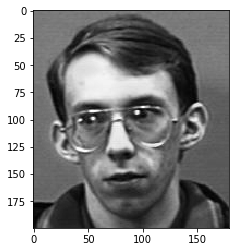

Computer recognized image:


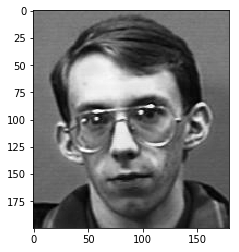

Randomly selected image:


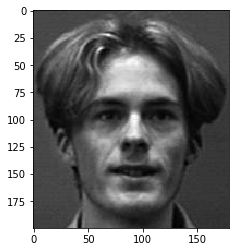

Computer recognized image:


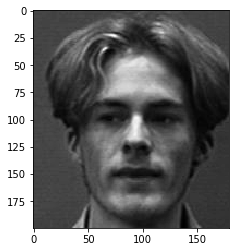

In [12]:
# Demonstration for three random faces
tests = sampleFaces(3)
for image in tests.T:
    index = fr.findNearest(image)
    print "Randomly selected image:"
    displayimage(image) # randomly generated image
    print "Computer recognized image:"
    displayimage(fr.F[:,index]) # computer recognized image

As we can clearly see in these three examples, given a random face that is present in the dataset, the computer can quickly and accurately recognize the face and return back who the computer thinks it is. 